# Consecutive dry days

In [1]:
import os
import sys
import folium

import numpy as np
import pandas as pd

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_default_line_colors
from ind_setup.core import fontsize


sys.path.append("../../../functions")
from data_downloaders import GHCN

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [3]:
df_country = GHCN.get_country_code(country)
print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

The GHCN code for Palau is PS


In [4]:
df_stations = GHCN.download_stations_info()
df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
print(f'There are {df_country_stations.shape[0]} stations in {country}')

There are 13 stations in Palau


In [5]:
GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'

In [6]:
id = 'PSW00040309' # Koror Station
dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]

/Users/laurac/Documents/HAWAII/repository_GItHub/CC_indicators/notebooks_historical/atmosphere/3_rainfall/../../../functions/data_downloaders.py:169: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url_download, na_values=['-9999'])


In [7]:
fig = plot_timeseries_interactive(dict_prcp, trendline=True, ylims = [None, None])

In [8]:
threshold = 1 #Threshold for dry and wet day
data = dict_prcp[0]['data']#.dropna()
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()
data['dry_day'] = np.where(data['PRCP'] < threshold, 1, 0)

In [9]:
def consecutive_dry_days(series):
    consec_dry = 0
    max_consec_dry = 0
    for value in series:
        if value:  # If it's a dry day (True)
            consec_dry += 1
        else:  # If it's not a dry day (False)
            max_consec_dry = max(max_consec_dry, consec_dry)
            consec_dry = 0
    return max_consec_dry

In [10]:
consecutive_dry_year = data.groupby(data.index.year)['dry_day'].apply(consecutive_dry_days)

In [11]:
threshold = 1
data['below_threshold'] = data['PRCP'] < threshold

# Función para calcular días consecutivos por debajo del umbral
def count_consecutive_days(series):
    count = 0
    result = []
    for value in series:
        if value:
            count += 1
        else:
            count = 0
        result.append(count)
    return result

# Aplica la función
data['consecutive_days'] = count_consecutive_days(data['below_threshold'])

<Axes: ylabel='Frequency'>

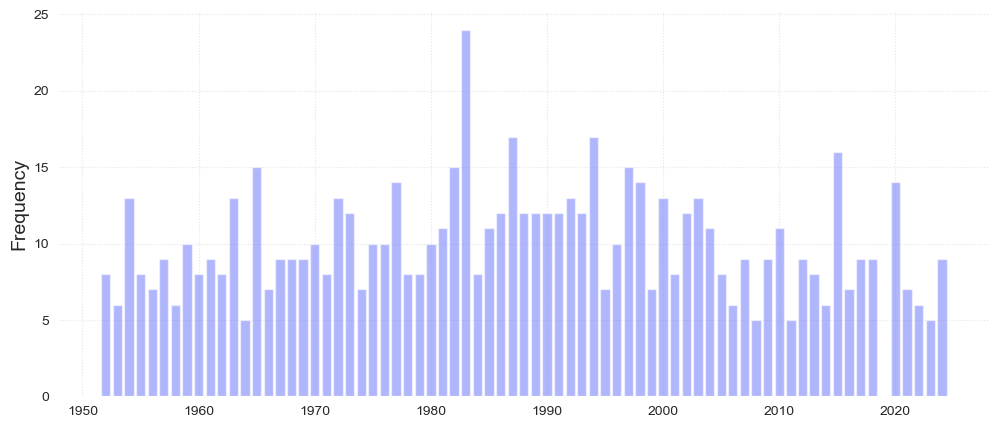

In [17]:
plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].max(), figsize = [12, 5])

In [13]:
datag = data.groupby(data.index.year).max()
datag.index = pd.to_datetime(datag.index, format = '%Y')
dict_plot = [{'data' : datag, 'var' : 'consecutive_days', 'ax' : 1, 'label':'Maximum number of consecutive days'},]


In [14]:
plot_timeseries_interactive(dict_plot, trendline = True,);